# Transferencia de Estilos con Redes Neuronales Profundas


En este notebook vamos a recrear una transferencia de estilo la cual está definida en el paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) usando PyTorch.

En el paper, la transferencia de estilo usa los features encontrados en la red VGG de 19 capas,  la cual son series comprimidas de capas convolucionales y algunas capas completamente conectadas. En la imagen de abajo las capas son nombradas por agrupación y su orden en el grupo. Conv_1_1 es la primera capa convolucional por la cual una imagen se pasa en la primera pila/grupo. Conv_2_1 es la primera capa convolucional en la segunda pila. La capa convolucional más profunda en la red es conv_5_4.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/style-transfer/notebook_ims/vgg19_convlayers.png?raw=1' width=80% />

### Separando el estilo y el contenido

La transferencia de estilo yace en separar el contenido y el estilo de una imagen. Dada una imagen de contenido y una de estilo apuntamos a crear una nueva imagen a la que definiremos como _target_  la cual deberá contener los componentes de nuestro contenido y estilo:
* Los objetos y sus arreglos son similares a los de **content image**
* Los estilos, colores y texturas son similares a los de **style image**

Un ejemplo se muestra donde el contenido es un gato y la imagen estilo es [Hokusai's Great Wave](https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa). La imagen objetivo es generada y todavía contiene al gato pero está estilizada con las olas y los colores azul y beige.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/style-transfer/notebook_ims/style_tx_cat.png?raw=1' width=80% />

Usaremos la red pre-entrenada VGG19 para extraer el contenido y estilo de imágenes que pasaremos. Luego formalizaremos la idea de content y style _losses_ y usaremos las actualizaciones iterativas para crear la imagen objetivo hasta obtener el resultado que querramos. Se los anima a que jueguen con las imágenes y los parámetros y compartan sus creaciones en instagram etiquetando a @ai_saturdays_guayaquil

In [0]:
# importando los recursos
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

## Cargando la red VGG19 (features)

VGG19 está dividida en 2 porciones:
* `vgg19.features`, la cual son todas las capas convolucionales.
* `vgg19.classifier`,  la cual son 3 capas clasificatorias al final.

Solo necesitaremos la porción `features` las que cargaremos y congelaremos los pesos.

In [2]:
# obtiene la porción "features" de VGG19
vgg = models.vgg19(pretrained=True).features

# congelamos todos los parámetros VGG dado que solo estamos optimizando la imagen objetivo
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
574673361it [00:06, 87960500.85it/s]


In [20]:
# mover el modelo a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### Cargando las imágenes  Content y Style 

¡Puedes cargar en cualquier imagen que quieras! A continuación, hemos proporcionado La función load_image para cargar imágenes de cualquier tipo y tamaño, también convierte imágenes a Tensores normalizados.

Además, será más fácil de usar.


In [0]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

A continuación, estoy cargando imágenes por nombre de archivo y forzando que la imagen de estilo tenga el mismo tamaño que la imagen de contenido.

In [0]:
# cargando las imágenes content y style
content = load_image('/content/puma.jpg').to(device)
# Redimensionar style para emparejar al content, hace más facil el trabajo
style = load_image('/content/fuego.JPG', shape=content.shape[-2:]).to(device)

In [0]:
# función para desnormalizar una imagen 
# y convertirla de una imagen Tensor a una imagen NumPy para su visualización
def im_convert(tensor):
    """ Muestra un tensor como una imagen. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

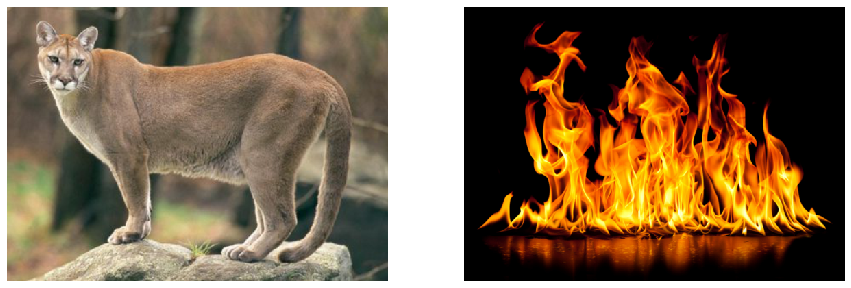

In [35]:
# muestra la imagen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
# content y style lado a lado
plt.axis('off')

ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax1.imshow(im_convert(content))

ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.imshow(im_convert(style))

---
## Capas VGG19

Para obtener el contenido y las representaciones de estilo de una imagen, debemos pasar una imagen hacia adelante a través de la red VGG19 hasta que lleguemos a la (s) capa (s) deseada (s) y luego obtengamos la salida de esa capa.

In [0]:
# imprime la estructura VGG19 para que pueda ver los nombres de varias capas
print(vgg)

## Content y  Style Features
###Contenido y características de estilo



In [0]:
def get_features(image, model, layers=None):
    """ Correr una imagen hacia adelante a través de un modelo y obtener las características para
        un conjunto de capas. Las capas predeterminadas son para VGGNet que coincida con Gatys et al (2016)
    """
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules es un diccionario que contiene cada módule en el modelo
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## Gram Matrix 

La salida de cada capa convolucional es un Tensor con dimensiones asociadas con el `batch_size`, una profundidad, `d` , altura y ancho (`h`, `w`). La Gram matrix de una capa convolucional puede ser calculada de la siguiente manera:
* Obtener la profundidad, alto y ancho  `batch_size, d, h, w = tensor.size`
* Redimensionar el tensor para que las dimensiones espaciales sean planas.
* Calcular la matrix gram multiplicando el tensor por su matriz transpuesta 



In [0]:
def gram_matrix(tensor):
   
    
    # obtiene el batch_size, profundidad, alto y ancho del Tensor
    _, d, h, w = tensor.size()
    
    # redimensiona para poder multiplicar los features para cada canal
    tensor = tensor.view(d, h * w)
    
    # calcula la gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

## Poniendo todo junto

Ahora que hemos escrito funciones para extraer características y calcular la matriz Gram de una capa convolucional dada; ¡Vamos a juntar todas estas piezas! Extraeremos nuestras características de nuestras imágenes y calcularemos las matrices Gram para cada capa en nuestra representación de estilo.

In [0]:
# obtiene los features de content y style features  una sola vez antes de entrenar
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calcula las matrices Gram para cada capa de nuestra representación de estilo
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# crea una tercera imagen, nuestra imagen objetivo/target, y la prepara para que cambie

target = content.clone().requires_grad_(True).to(device)

---
## Loss y Weights
###Pérdidas y pesos 

#### Pesos de estilo de capa individual

A continuación, se le da la opción de ponderar la representación del estilo en cada capa relevante. Se sugiere que utilice un rango entre 0-1 para ponderar estas capas. Al ponderar más las capas anteriores (`conv1_1` y` conv2_1`), puede esperar obtener artefactos de estilo _larger_ en su imagen objetivo resultante. Si elige ponderar las capas posteriores, obtendrá más énfasis en las funciones más pequeñas. ¡Esto se debe a que cada capa tiene un tamaño diferente y juntas crean una representación de estilo de escala múltiple!

#### Pesos de contenido y estilo

Al igual que en el paper, definimos un alfa (`content_weight`) y un beta (` style_weight`). Esta relación afectará a cómo está _estilizada_ tu imagen final. Se recomienda dejar el content_weight = 1 y configurar el style_weight para lograr la proporción que desea.

In [0]:
# weights para cada capa de estilo 
# note que excluimos `conv4_2` de nuestra representación de contenido
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

## Actualizando el Target & Calculando las pérdidas

Usted decidirá sobre una serie de pasos para actualizar su imagen, esto es similar al ciclo de entrenamiento que ha visto antes, solo que estamos cambiando nuestra imagen _target_ y nada más sobre VGG19 o cualquier otra imagen. Por lo tanto, la cantidad de pasos depende realmente de usted! ** Recomiendo usar al menos 2000 pasos para obtener buenos resultados. ** Pero es posible que desee comenzar con menos pasos si solo está probando diferentes valores de peso o experimentando con diferentes imágenes.

Dentro del bucle de iteración, calculará el contenido y las pérdidas de estilo y actualizará su imagen de destino, según corresponda.



#### Pérdida de contenido / Content Loss

La pérdida de contenido será la diferencia cuadrática media entre las características de destino y de contenido en la capa `conv4_2`. Esto se puede calcular de la siguiente manera:
```
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```

#### Pérdida de Estilo / Style Loss


La pérdida de estilo se calcula de manera similar, solo usted tiene que recorrer una serie de capas, especificadas por nombre en nuestro diccionario `style_weights`.
> Calcularás la matriz Gram para la imagen de destino, `target_gram` y la imagen de estilo` style_gram` en cada una de estas capas y compararás esas matrices , calculando el `layer_style_loss`.
> Más adelante, verás que este valor está normalizado por el tamaño de la capa.


#### Pérdida total / Total Loss

Finalmente, creará la pérdida total sumando las pérdidas de estilo y contenido y ponderándolas con su alfa y beta especificados.

De manera intermitente, imprimiremos esta pérdida; No se alarme si la pérdida es muy grande. Se necesita algo de tiempo para que el estilo de una imagen cambie y debe centrarse en la apariencia de su imagen de destino en lugar de cualquier valor de pérdida. Aún así, debería ver que esta pérdida disminuye con algunas iteraciones.


Total loss:  30996359168.0
Iteration #  250


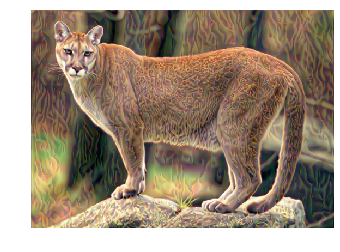

Total loss:  20774893568.0
Iteration #  500


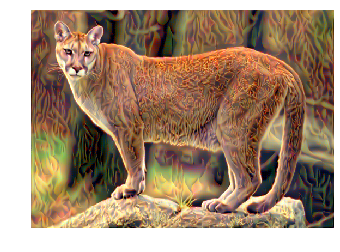

Total loss:  13483308032.0
Iteration #  750


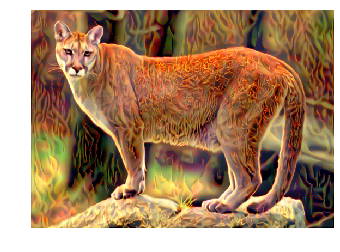

Total loss:  8192148480.0
Iteration #  1000


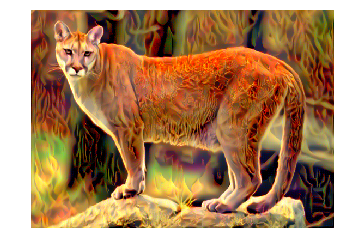

Total loss:  5379748352.0
Iteration #  1250


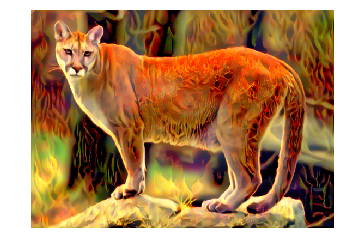

Total loss:  4141261568.0
Iteration #  1500


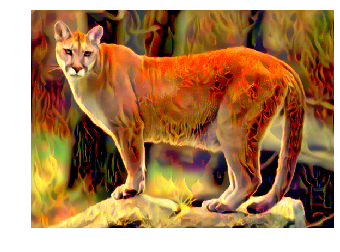

Total loss:  3473789952.0
Iteration #  1750


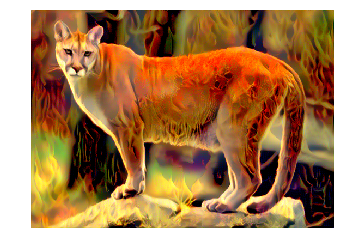

Total loss:  3016545536.0
Iteration #  2000


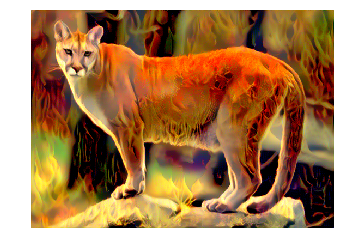

Total loss:  2659947008.0
Iteration #  2250


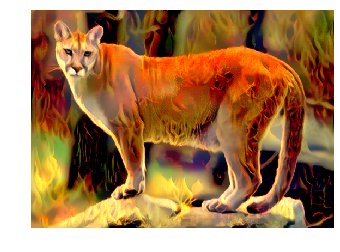

Total loss:  2365384704.0
Iteration #  2500


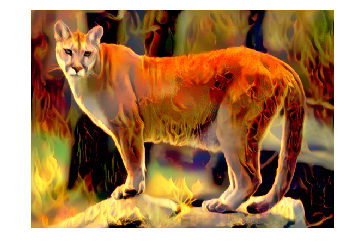

Total loss:  2116146432.0
Iteration #  2750


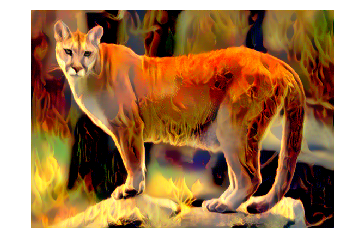

Total loss:  1896684416.0
Iteration #  3000


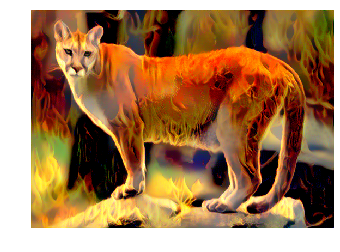

Total loss:  1704841856.0
Iteration #  3250


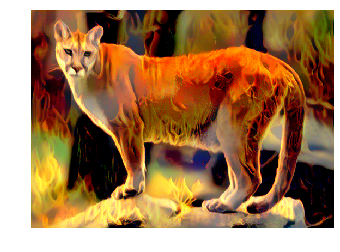

Total loss:  1529309696.0
Iteration #  3500


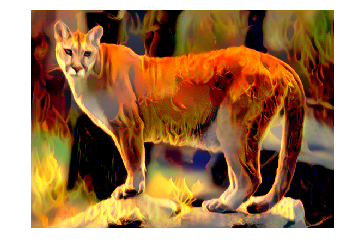

Total loss:  1373404672.0
Iteration #  3750


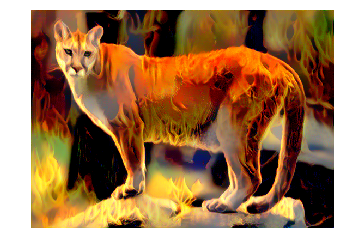

Total loss:  1234914560.0
Iteration #  4000


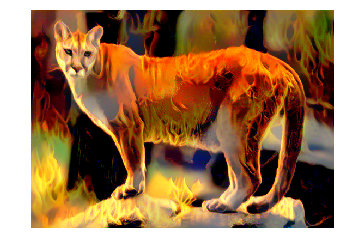

Total loss:  1109078016.0
Iteration #  4250


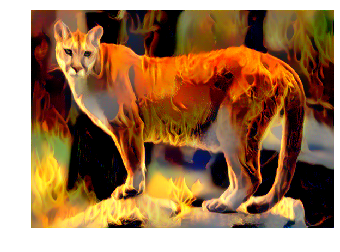

Total loss:  990446976.0
Iteration #  4500


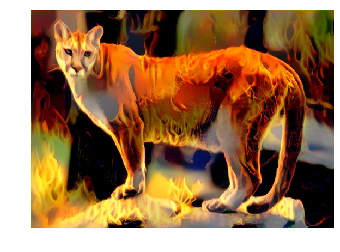

Total loss:  879497408.0
Iteration #  4750


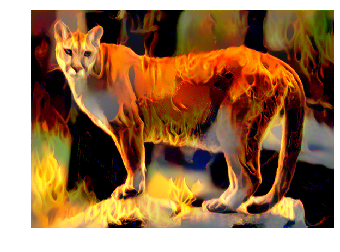

Total loss:  777562624.0
Iteration #  5000


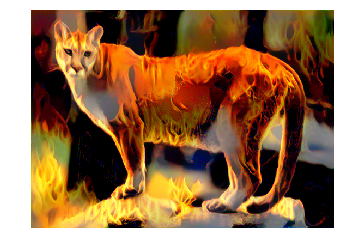

In [40]:
# cada cuantos pasos se mostrará un avance
show_every = 250

# hyperparametros de iteración
optimizer = optim.Adam([target], lr=0.003)
steps = 5000  # cuantas iteraciónes tomará la imagen

for ii in range(1, steps+1):
    
    # obtiene los features de la imagen objetivo/target
    target_features = get_features(target, vgg)
    
    # la perdida de contenido
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # la perdida de estilo
    # inicializa en 0
    style_loss = 0
    # luego se suma cada pérdida de capa de matriz Gram
    for layer in style_weights:
        # obtiene la representación de estilo de la imagen objetivo para la capa
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # obtiene la representación de estilo
        style_gram = style_grams[layer]
        # la pérdida de estilo para una capa multiplicada por su beta
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # suma las pérdidas de estilo
        style_loss += layer_style_loss / (d * h * w)
        
    # calcula la pérdida total
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # actualiza la imagen objetivo
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # muestra las imágenes intermedias e imprime la pérdida y el número de iteración
    if  ii % show_every == 0:
        print('Pérdida total / Total loss: ', total_loss.item())
        print('Iteración # ', ii)
        plt.imshow(im_convert(target))
        plt.axis('off')
        plt.show()

##Mostrando la imagen final (Target)

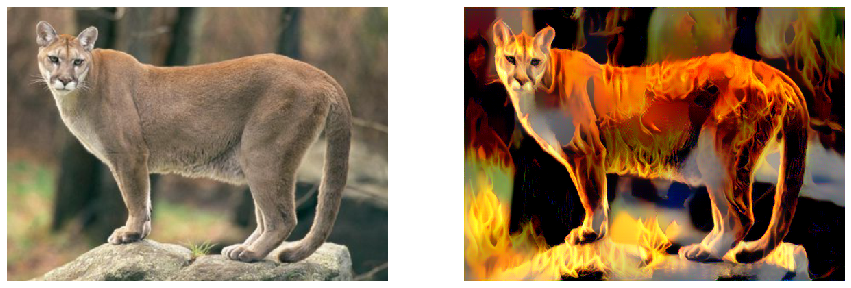

In [42]:
# Muestra la imagen original (content) y la imagen final (target)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax1.imshow(im_convert(content))

ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.imshow(im_convert(target))